In [1]:
# The cache directories:
cache_path       = '/Users/jh7685/Documents/Github/hcp-annot-vc-data/'
image_cache_path = f'{cache_path}/annot-images'
v123_cache_path  = f'{cache_path}/annot-v123'
csulc_cache_path = f'{cache_path}/annot-csulc'
trace_save_path = f'{cache_path}/hcp-annot-vc/save'
labels_path = f'{cache_path}/results/labels'

import os
# If you aren't using /data
os.environ['HCPANNOT_LOAD_PATH'] = cache_path

In [11]:
import os 
import sys
sys.path.append('..')
from visualization import plot_contours as vis
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## figure setting
For some reason the only font family I could found was serif.

In [12]:
import pylab as pl
la = pl.matplotlib.font_manager.FontManager()
lu = pl.matplotlib.font_manager.FontProperties(family = 'monospace')
la.findfont(lu)

'/Users/jh7685/opt/miniconda3/envs/sfp/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf'

In [13]:
import matplotlib as mpl
# Additional matplotlib preferences:
font_data = {'size': 10,
             'weight': 'light',
            'family': 'monospace'} # missing fonts 
mpl.rc('font', **font_data) 
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72 * 2
mpl.rcParams['savefig.dpi'] = 72 * 4

In [14]:
# Now we can import the hcp-annot-vc library.
import hcpannot
hcpannot.interface.default_load_path = cache_path
from hcpannot import (vc_plan,
                      save_contours,
                      load_contours,
                      subject_ids)

In [15]:
rater_list = ['BrendaQiu',
              'bogengsong',
              'JiyeongHa',
              'lindazelinzhao',
              'nourahboujaber',
              'jennifertepan']

## Helper functions for plotting mean contours across subjects

In [23]:
rater='JiyeongHa'
sid=100610
hemi='lh'
roi='hV4'
n_points=100
cache_file = os.path.join(cache_path, 'traces', f"contour-path_space-fsaverage_rater-{rater}_sid-{sid}_hemi-{hemi}_roi-{roi}_npoints-{n_points}.mgz")

In [20]:
from glob import glob
jh_list = glob(os.path.join(trace_save_path, 'JiyeongHa/*/lh.hV4_VO1.json'))
jh_subj_ids = [int(k.split('/')[-2]) for k in jh_list]
print(len(jh_subj_ids))
jh_subj_ids[:3]
#ny.cortex - to plot flatten functional maps

181


[239136, 195041, 180533]

In [24]:
x, y = vis.make_trace('JiyeongHa',
                       'lh',
                       'hV4',
                       jh_subj_ids[0],
                       100,
                       True,
                       cache_file,
                       trace_save_path)

---------------------
subject no.239136
loading surface mesh....
done! elpased time is 0.0 sec.
Now converting trace to path...
done! elpased time is 8.196 sec
Now transforming the path to fsaverage space...
done! elpased time is 3.895 sec.
now interpolating the coordinates..
subject no. 239136 is finished! Elapsed time: 12.09 sec


In [30]:
vis.get_contour_list_drawn_by_rater(trace_save_path, '*', '*', 'JiyeongHa')

[239136,
 239136,
 239136,
 239136,
 239136,
 239136,
 239136,
 239136,
 239136,
 239136,
 195041,
 195041,
 195041,
 195041,
 195041,
 195041,
 195041,
 195041,
 195041,
 195041,
 180533,
 180533,
 180533,
 180533,
 180533,
 180533,
 180533,
 180533,
 654552,
 654552,
 654552,
 654552,
 654552,
 654552,
 654552,
 654552,
 157336,
 157336,
 157336,
 157336,
 157336,
 157336,
 157336,
 157336,
 157336,
 157336,
 157336,
 200210,
 200210,
 200210,
 200210,
 200210,
 200210,
 200210,
 200210,
 572045,
 572045,
 572045,
 572045,
 572045,
 572045,
 572045,
 572045,
 178142,
 178142,
 178142,
 178142,
 178142,
 178142,
 178142,
 178142,
 552241,
 552241,
 552241,
 552241,
 552241,
 552241,
 552241,
 552241,
 175237,
 175237,
 175237,
 175237,
 175237,
 175237,
 175237,
 175237,
 175237,
 175237,
 175237,
 187345,
 187345,
 187345,
 187345,
 187345,
 187345,
 187345,
 187345,
 187345,
 789373,
 789373,
 789373,
 789373,
 789373,
 789373,
 789373,
 789373,
 111514,
 111514,
 111514,
 111514,
 

## Plot functions

## Test

had to fork neuropythy & git clone the fork and pip install -e . and then edit all np.object to object.
Downgrading numpy==1.25.5 or the version listed on the neuropythy document was not successful due to another error on the top importing ipython-related packages

In [38]:
rater = 'JiyeongHa'
normed_fsa_coords_dict = main(rater=rater, 
                              roi='hV4', 
                              subject_list=jh_subj_ids[:30], 
                              hemi='lh', 
                              n_points=600, 
                              verbose=True,
                              trace_save_path=trace_save_path)

**number of subjects: 30
**nuber of points:600


  0%|          | 0/30 [00:00<?, ?it/s]

---------------------
subject no.176542
loading surface mesh....
done! elpased time is 0.707 sec.
Now converting trace to path...
done! elpased time is 9.653 sec
Now transforming the path to fsaverage space...
done! elpased time is 1.37 sec.
now interpolating the coordinates..
subject no. 176542 is finished! Total time: 11.74 sec
---------------------
subject no.927359
loading surface mesh....
done! elpased time is 0.681 sec.
Now converting trace to path...
done! elpased time is 44.959 sec
Now transforming the path to fsaverage space...
done! elpased time is 1.691 sec.
now interpolating the coordinates..
subject no. 927359 is finished! Total time: 47.34 sec
---------------------
subject no.146735
loading surface mesh....
done! elpased time is 0.636 sec.
Now converting trace to path...
done! elpased time is 7.864 sec
Now transforming the path to fsaverage space...
done! elpased time is 1.101 sec.
now interpolating the coordinates..
subject no. 146735 is finished! Total time: 9.6 sec
---

done! elpased time is 1.413 sec.
now interpolating the coordinates..
subject no. 751550 is finished! Total time: 12.46 sec
---------------------
subject no.671855
loading surface mesh....
done! elpased time is 0.68 sec.
Now converting trace to path...
done! elpased time is 105.02 sec
Now transforming the path to fsaverage space...
done! elpased time is 1.529 sec.
now interpolating the coordinates..
subject no. 671855 is finished! Total time: 107.23 sec
---------------------
subject no.164636
loading surface mesh....
done! elpased time is 0.665 sec.
Now converting trace to path...
done! elpased time is 10.916 sec
Now transforming the path to fsaverage space...
done! elpased time is 1.534 sec.
now interpolating the coordinates..
subject no. 164636 is finished! Total time: 13.12 sec
---------------------
subject no.169444
loading surface mesh....
done! elpased time is 0.669 sec.
Now converting trace to path...
done! elpased time is 9.531 sec
Now transforming the path to fsaverage space...

## Plot

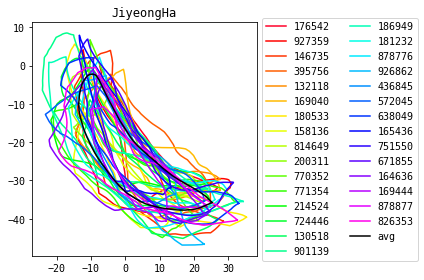

In [39]:
plot_multiple_traces(normed_fsa_coords_dict, 
                     average_only=False, 
                     title=rater)

## for savings..